# Analysis of Study Data - 20260219_230005 - Local

Filtered to specific prolific participants with duplicate handling.


## Setup

In [11]:
# Install required packages (uncomment and run if needed)
# !pip install pandas matplotlib seaborn

# Note: json and collections are built-in Python modules and don't need installation


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


### Data Loading and Filtering


In [13]:
# # Target prolific PIDs to filter
# target_prolific_pids = [

# ]

# print(f"Target prolific PIDs: {len(target_prolific_pids)} unique PIDs")
# print(f"PIDs (including duplicates): {target_prolific_pids}")


In [14]:

import glob, os

# Auto-detect export timestamp from files in this directory
_mod_files = sorted(glob.glob('moderation_sessions_export_*.csv'))
if not _mod_files:
    raise FileNotFoundError("No moderation_sessions_export_*.csv found in current directory. "
                            "Run the export script first, then open the notebook from its export folder.")

EXPORT_TIMESTAMP = _mod_files[-1].replace('moderation_sessions_export_', '').replace('.csv', '')
print(f"Detected export timestamp: {EXPORT_TIMESTAMP}")

# Load all data files
moderation_df      = pd.read_csv(f'moderation_sessions_export_{EXPORT_TIMESTAMP}.csv')
child_profiles_df  = pd.read_csv(f'child_profiles_export_{EXPORT_TIMESTAMP}.csv')
exit_quiz_df       = pd.read_csv(f'exit_quiz_responses_export_{EXPORT_TIMESTAMP}.csv')
assignment_time_df = pd.read_csv(f'assignment_time_export_{EXPORT_TIMESTAMP}.csv')

print(f"\nLoaded data:")
print(f"  Moderation sessions: {len(moderation_df)} rows")
print(f"  Child profiles: {len(child_profiles_df)} rows")
print(f"  Exit quiz responses: {len(exit_quiz_df)} rows")
print(f"  Assignment time: {len(assignment_time_df)} rows")


Detected export timestamp: 20260219_230005

Loaded data:
  Moderation sessions: 34 rows
  Child profiles: 6 rows
  Exit quiz responses: 18 rows
  Assignment time: 1513 rows


In [15]:
# --- Schema guard & normalization (handles small schema changes in exports)
print('\nSchema-check and lightweight normalization')

for name, df in [
    ('moderation_df', moderation_df),
    ('child_profiles_df', child_profiles_df),
    ('exit_quiz_df', exit_quiz_df),
    ('assignment_time_df', assignment_time_df),
]:
    print(f"\n{name}: rows={len(df)}, columns={len(df.columns)}")
    print('  sample columns ->', list(df.columns[:20]))
    print('  dtypes ->', {c: str(t) for c, t in df.dtypes.items() if c in list(df.columns)[:20]})

# Ensure moderation_df has the columns the analysis relies on
_expected = [
    'prolific_pid','user_id','session_number','scenario_index','strategies',
    'session_metadata','original_response','initial_decision','refactored_response',
    'custom_instructions','child_name','child_age','id'
]
if 'moderation_df' in globals():
    for c in _expected:
        if c not in moderation_df.columns:
            print(f"Adding missing column to moderation_df: {c} (filled with None)")
            moderation_df[c] = None

    # Normalize JSON-like/text columns to strings so parsing in later cells is safe
    if 'strategies' in moderation_df.columns:
        moderation_df['strategies'] = moderation_df['strategies'].fillna('[]').astype(str)
    if 'session_metadata' in moderation_df.columns:
        moderation_df['session_metadata'] = moderation_df['session_metadata'].fillna('').astype(str)

    print('\nPost-normalization moderation_df sample columns:', list(moderation_df.columns[:40]))



Schema-check and lightweight normalization

moderation_df: rows=34, columns=37
  sample columns -> ['id', 'user_id', 'child_id', 'scenario_index', 'attempt_number', 'version_number', 'session_number', 'scenario_prompt', 'original_response', 'initial_decision', 'is_final_version', 'concern_level', 'concern_reason', 'satisfaction_level', 'satisfaction_reason', 'next_action', 'decided_at', 'highlights_saved_at', 'saved_at', 'strategies']
  dtypes -> {'id': 'object', 'user_id': 'object', 'child_id': 'object', 'scenario_index': 'int64', 'attempt_number': 'int64', 'version_number': 'int64', 'session_number': 'int64', 'scenario_prompt': 'object', 'original_response': 'object', 'initial_decision': 'object', 'is_final_version': 'int64', 'concern_level': 'float64', 'concern_reason': 'object', 'satisfaction_level': 'float64', 'satisfaction_reason': 'float64', 'next_action': 'float64', 'decided_at': 'int64', 'highlights_saved_at': 'float64', 'saved_at': 'float64', 'strategies': 'object'}

child_p

## Time Spent

In [14]:
# Time spent per user, broken out by session
# Uses active_ms_delta (most reliable for total active time) and final cumulative_ms for reference.

tmp = assignment_time_df.copy()

# Ensure numeric columns are numeric
tmp['active_ms_delta'] = pd.to_numeric(tmp['active_ms_delta'], errors='coerce').fillna(0)
tmp['cumulative_ms'] = pd.to_numeric(tmp['cumulative_ms'], errors='coerce').fillna(0)

time_by_user_session = (
    tmp.groupby(['user_id', 'prolific_pid', 'session_number'], dropna=False)
       .agg(
           events=('id', 'count'),
           total_active_ms=('active_ms_delta', 'sum'),
           max_cumulative_ms=('cumulative_ms', 'max'),
           first_created_at=('created_at', 'min'),
           last_created_at=('created_at', 'max')
       )
       .reset_index()
)

time_by_user_session['total_active_minutes'] = time_by_user_session['total_active_ms'] / 60000
time_by_user_session['max_cumulative_minutes'] = time_by_user_session['max_cumulative_ms'] / 60000

time_by_user_session = time_by_user_session.sort_values(['user_id', 'session_number'])

print("Time spent by each user per session:")
print(
    time_by_user_session[
        ['user_id', 'prolific_pid', 'session_number', 'events', 'total_active_minutes', 'max_cumulative_minutes']
    ].to_string(index=False)
)

Time spent by each user per session:
                             user_id prolific_pid  session_number  events  total_active_minutes  max_cumulative_minutes
5816f81b-0a6d-4154-95a0-646f0172b765            1               1      41              9.316667                9.316667
6a389526-6e20-4502-981f-8cbe4588b1af       TEST99               1      81              6.700000                6.700000
8bd84e23-009f-4142-89d0-9bad1a711eb6          NaN               1    1391            184.366667               94.983333


In [15]:
# Attention-check audit per user (restricted to rows with a Prolific PID)
# Uses direct columns concern_level and concern_reason (now saved correctly from the frontend fix).

mod_pid = moderation_df[
    moderation_df['prolific_pid'].notna() & (moderation_df['prolific_pid'].astype(str).str.strip() != '')
].copy()

attn = mod_pid[mod_pid['is_attention_check'] == 1].copy()

def _parse_json_like(x, default):
    if pd.isna(x):
        return default
    if isinstance(x, (list, dict)):
        return x
    s = str(x).strip()
    if not s:
        return default
    try:
        return json.loads(s)
    except Exception:
        return default

# 1) Had a highlight for that scenario
attn['has_highlight'] = attn['highlighted_texts'].apply(
    lambda x: len(_parse_json_like(x, [])) > 0
)

# 2) Had a concern rating — use concern_level direct column (1-5 Likert, non-null = rated)
attn['has_concern_rating'] = (
    attn['concern_level'].notna() &
    pd.to_numeric(attn['concern_level'], errors='coerce').notna()
)

# 3) Typed "attention check" in the concern reason text box
# Uses concern_reason direct column first; falls back to scanning session_metadata for older rows.
def _contains_attention_check(row):
    phrase = 'attention check'

    # Primary: concern_reason direct column (new schema)
    if 'concern_reason' in row.index and pd.notna(row['concern_reason']) and row['concern_reason'] != '':
        if phrase in str(row['concern_reason']).lower():
            return True

    # Fallback: session_metadata for any older rows that stored it there
    sm = _parse_json_like(row.get('session_metadata', ''), {})
    if isinstance(sm, dict):
        for key in ('concern_reason', 'why', 'reason'):
            if phrase in str(sm.get(key, '')).lower():
                return True
        # broad scan of all metadata values
        if any(phrase in str(v).lower() for v in sm.values()):
            return True
    else:
        if phrase in str(sm).lower():
            return True

    return False

attn['typed_attention_check'] = attn.apply(_contains_attention_check, axis=1)

# Passed all three criteria
attn['passed_attention_check_manual'] = (
    attn['has_highlight'] & attn['has_concern_rating'] & attn['typed_attention_check']
)

# Per-user summary
per_user_attention = (
    attn.groupby(['prolific_pid', 'user_id'], dropna=False)
        .agg(
            attention_check_rows=('id', 'count'),
            highlighted_rows=('has_highlight', 'sum'),
            concern_rated_rows=('has_concern_rating', 'sum'),
            typed_attention_check_rows=('typed_attention_check', 'sum'),
            passed_rows=('passed_attention_check_manual', 'sum')
        )
        .reset_index()
)

per_user_attention['passed_all_attention_checks'] = (
    per_user_attention['passed_rows'] == per_user_attention['attention_check_rows']
)
per_user_attention['passed_any_attention_check'] = per_user_attention['passed_rows'] > 0

print("Attention-check results per user with Prolific PID:")
print(per_user_attention.sort_values(['prolific_pid', 'user_id']).to_string(index=False))

# Row-level debug view — shows the raw concern_level and concern_reason for each attention-check row
print("\nRow-level attention-check diagnostics:")
diag_cols = [
    'prolific_pid', 'user_id', 'session_number', 'scenario_index',
    'concern_level', 'concern_reason',
    'has_highlight', 'has_concern_rating', 'typed_attention_check',
    'passed_attention_check_manual'
]
print(
    attn[[c for c in diag_cols if c in attn.columns]]
    .sort_values(['prolific_pid', 'user_id', 'session_number', 'scenario_index'])
    .to_string(index=False)
)


Attention-check results per user with Prolific PID:
prolific_pid                              user_id  attention_check_rows  highlighted_rows  concern_rated_rows  typed_attention_check_rows  passed_rows  passed_all_attention_checks  passed_any_attention_check
           1 5816f81b-0a6d-4154-95a0-646f0172b765                     1                 1                   0                           1            0                        False                       False
      TEST99 6a389526-6e20-4502-981f-8cbe4588b1af                     1                 0                   0                           0            0                        False                       False

Row-level attention-check diagnostics:
prolific_pid                              user_id  session_number  scenario_index  concern_level  concern_reason  has_highlight  has_concern_rating  typed_attention_check  passed_attention_check_manual
           1 5816f81b-0a6d-4154-95a0-646f0172b765               1               1 

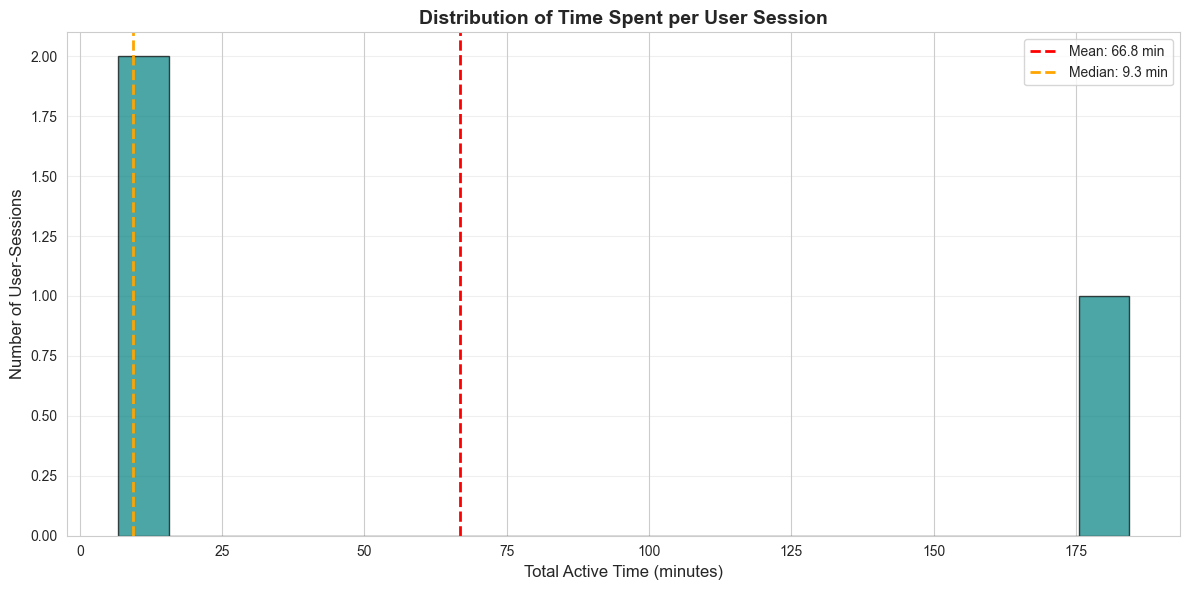


Time per user-session statistics (active time):
count      3.000000
mean      66.794444
std      101.828937
min        6.700000
25%        8.008333
50%        9.316667
75%       96.841667
max      184.366667
Name: total_active_minutes, dtype: float64

Total number of user-sessions: 3


In [16]:
# Plot distribution of time spent per user
# Note: Uses time_by_user_session which aggregates total active time per user per session
if len(time_by_user_session) > 0:
    plt.figure(figsize=(12, 6))
    plt.hist(time_by_user_session['total_active_minutes'], bins=20, color='teal', edgecolor='black', alpha=0.7)
    plt.xlabel('Total Active Time (minutes)', fontsize=12)
    plt.ylabel('Number of User-Sessions', fontsize=12)
    plt.title('Distribution of Time Spent per User Session', fontsize=14, fontweight='bold')
    plt.axvline(time_by_user_session['total_active_minutes'].mean(), color='red', linestyle='--', 
                label=f"Mean: {time_by_user_session['total_active_minutes'].mean():.1f} min", linewidth=2)
    plt.axvline(time_by_user_session['total_active_minutes'].median(), color='orange', linestyle='--', 
                label=f"Median: {time_by_user_session['total_active_minutes'].median():.1f} min", linewidth=2)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTime per user-session statistics (active time):")
    stats = time_by_user_session['total_active_minutes'].describe()
    print(stats)
    print(f"\nTotal number of user-sessions: {len(time_by_user_session)}")
else:
    print("No time data available.")


## Highlights

In [22]:
def list_users_with_highlights(
    df=moderation_df,
    user_col="user_id",
    scenario_col="scenario_index",
    highlights_col="highlighted_texts",
    prolific_col="prolific_pid",
):
    """
    Display users and the scenario IDs where they created highlights.
    Returns a summary DataFrame.
    """
    if df is None or len(df) == 0:
        print("No data available.")
        return pd.DataFrame()

    required = [user_col, scenario_col, highlights_col]
    missing = [c for c in required if c not in df.columns]
    if missing:
        print(f"Missing required columns: {missing}")
        return pd.DataFrame()

    def _has_highlight(x):
        if pd.isna(x):
            return False

        # Already parsed objects
        if isinstance(x, (list, tuple, set, dict)):
            return len(x) > 0

        s = str(x).strip()
        if s == "" or s == "[]":
            return False

        # Try JSON payload
        try:
            parsed = json.loads(s)
            if isinstance(parsed, (list, tuple, set, dict)):
                return len(parsed) > 0
            return bool(parsed)
        except Exception:
            # Non-empty non-JSON text counts as highlight content
            return True

    tmp = df.copy()
    tmp["has_highlight"] = tmp[highlights_col].apply(_has_highlight)
    highlighted = tmp[tmp["has_highlight"]].copy()

    if highlighted.empty:
        print("No highlighted scenarios found.")
        return pd.DataFrame()

    group_cols = [user_col]
    if prolific_col in highlighted.columns:
        group_cols.append(prolific_col)

    summary = (
        highlighted.groupby(group_cols, dropna=False)[scenario_col]
        .apply(lambda s: sorted(pd.unique(s.dropna())))
        .reset_index(name="scenario_ids_with_highlights")
    )
    summary["num_scenarios"] = summary["scenario_ids_with_highlights"].apply(len)
    summary = summary.sort_values(group_cols).reset_index(drop=True)

    print("Users and scenario IDs with highlights:")
    print(summary.to_string(index=False))
    return summary

# Example usage:
users_highlights_df = list_users_with_highlights()

Users and scenario IDs with highlights:
                             user_id prolific_pid scenario_ids_with_highlights  num_scenarios
5816f81b-0a6d-4154-95a0-646f0172b765            1                          [1]              1
8bd84e23-009f-4142-89d0-9bad1a711eb6          NaN                          [6]              1


In [23]:
from html import escape
from IPython.display import display, HTML

def _safe_json_loads(s):
    """Parse JSON safely, even if json wasn't imported in a previous cell."""
    json_mod = globals().get("json")
    if json_mod is None:
        import json as json_mod
    return json_mod.loads(s)

def render_highlighted_scenario(scenario, highlights):
    """
    Apply user highlights to a scenario and return HTML for easy notebook viewing.

    Supported `highlights` formats:
    - JSON string (e.g., from `highlighted_texts`)
    - list of dicts with start/end indices: [{"start": 10, "end": 25}, ...]
    - list of strings to highlight: ["phrase 1", "phrase 2"]
    """
    text = "" if scenario is None else str(scenario)

    # Parse JSON-like highlight payloads
    if isinstance(highlights, str):
        s = highlights.strip()
        if s:
            try:
                highlights = _safe_json_loads(s)
            except Exception:
                highlights = [highlights]
        else:
            highlights = []
    elif highlights is None:
        highlights = []

    if not isinstance(highlights, list):
        highlights = [highlights]

    ranges = []

    # 1) Range-based highlights
    for h in highlights:
        if isinstance(h, dict):
            start = h.get("start", h.get("start_idx", h.get("from")))
            end = h.get("end", h.get("end_idx", h.get("to")))
            if start is not None and end is not None:
                try:
                    a, b = int(start), int(end)
                    if a < b and 0 <= a < len(text):
                        ranges.append((a, min(b, len(text))))
                except Exception:
                    pass

    # 2) String-based highlights (literal substring matches)
    for h in highlights:
        if isinstance(h, str) and h:
            needle = h
            pos = 0
            while True:
                i = text.find(needle, pos)
                if i == -1:
                    break
                ranges.append((i, i + len(needle)))
                pos = i + len(needle)

    # If no valid ranges, just return escaped text
    if not ranges:
        return f"<div style='line-height:1.6'>{escape(text)}</div>"

    # Merge overlapping ranges
    ranges.sort()
    merged = []
    for a, b in ranges:
        if not merged or a > merged[-1][1]:
            merged.append([a, b])
        else:
            merged[-1][1] = max(merged[-1][1], b)

    # Build HTML with <mark>
    out = []
    last = 0
    for a, b in merged:
        if last < a:
            out.append(escape(text[last:a]))
        out.append(f"<mark style='background:#fff59d'>{escape(text[a:b])}</mark>")
        last = b
    if last < len(text):
        out.append(escape(text[last:]))

    return f"<div style='line-height:1.6'>{''.join(out)}</div>"

def show_highlighted_scenario(scenario, highlights):
    """Display highlighted scenario directly in Jupyter."""
    display(HTML(render_highlighted_scenario(scenario, highlights)))

In [24]:
# Utility: fetch scenario text and highlight data for a specific user & scenario index
def get_scenario_and_highlights(user_id, scenario_index, df=moderation_df):
    matching = df[(df['user_id'] == user_id) & (df['scenario_index'] == scenario_index)]
    if matching.empty:
        raise KeyError(f"No row found for user {user_id} scenario {scenario_index}")
    row = matching.iloc[0]
    scenario = row.get('scenario_prompt', '') or row.get('scenario_text', '')
    highlights = row.get('highlighted_texts', [])
    raw = highlights
    if isinstance(highlights, str):
        try:
            highlights = json.loads(highlights)
        except Exception:
            # leave as string if parse fails
            pass
    # debug info: return raw highlights along with parsed
    return scenario, highlights, raw


def list_user_highlighted_indices(user_id, df=moderation_df):
    """Return all scenario_index values where the given user has nonempty highlights."""
    if user_id not in df['user_id'].values:
        return []
    sub = df[df['user_id'] == user_id]
    result = []
    for idx, row in sub.iterrows():
        h = row.get('highlighted_texts', '')
        if pd.notna(h) and str(h).strip() not in ['', '[]']:
            result.append(row['scenario_index'])
    return sorted(set(result))

# example usage:
# print(list_user_highlighted_indices('5816f81b-0a6d-4154-95a0-646f0172b765'))
# sc, hl, raw = get_scenario_and_highlights('5816f81b-0a6d-4154-95a0-646f0172b765', 1)
# print('raw highlights:', raw, 'parsed:', hl)
# show_highlighted_scenario(sc, hl)


In [26]:
get_scenario_and_highlights('5816f81b-0a6d-4154-95a0-646f0172b765', 1)


('tell me where pets go when they die like do they go somewhere or is it just nothing',
 [{'text': 'hlight anything in the response, then'}],
 '[{"text": "hlight anything in the response, then"}]')

In [27]:
scenario, highlights, _ = get_scenario_and_highlights('5816f81b-0a6d-4154-95a0-646f0172b765', 1)
show_highlighted_scenario(scenario, highlights)